In [1]:
# Copyright (C) 2020-2021  Mael Kerbiriou <piezo.wdimd@gmail.com>
#
# This file may be distributed under the terms of the GNU GPLv3 license.
from contextlib import contextmanager
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.style.use(['dark_background'])

plt_kwargs = dict(
    toolhead=dict(color=(.5,.5,1), zorder=20),
    X=dict(color='red'),
    Y=dict(color=(.0,.8,.0)),
    A=dict(color='cyan'),
    B=dict(color='yellow'),
    )
for k in plt_kwargs: plt_kwargs[k]['linewidth'] = 1.25
plt_kwargs['toolhead']['linewidth'] = 3

@contextmanager
def fig_tmpl(title, ordinate):
    f = plt.figure(figsize=(10,5))
    plt.grid(False)
    plt.title(title)
    plt.xlabel('Move orientation (°)')
    plt.ylabel('Max %s (relative)' % ordinate)
    plt.xticks(np.linspace(0,180,4*3, endpoint=False))
    try:
        yield f
    finally:
        _, ymax = plt.ylim()
        plt.ylim((0,ymax))
        plt.xlim((0,180))

        plt.legend(loc='lower right')
        plt.tight_layout()
        
        
@contextmanager
def fig_tmpl(title, ordinate):
    f = plt.figure(figsize=(7,7))
    ax = f.add_subplot(projection='polar')
    
    #ax.set_thetamin(0)
    #ax.set_thetamax(180)

    plt.grid(c='gray', linewidth=0.5, linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Move orientation (°)')
    #plt.ylabel('Max %s (relative)' % ordinate)
    #plt.xticks(np.linspace(0,180,4*3, endpoint=False))
    try:
        yield f
    finally:
        _, ymax = plt.ylim()
        plt.ylim((0,ymax))
        #plt.xlim((0,180))

        plt.legend(loc='lower right')
        plt.tight_layout()
        
def gen_moves(theta):
    d = np.random.rand(*theta.shape)*10+1 # Random move lengths
    return d*np.cos(theta), d*np.sin(theta)

theta = np.linspace(0,2*np.pi, 127)
theta_deg = (180/np.pi) * theta
x,y = gen_moves(theta)
d = np.hypot(x,y)

## Cartesian

### Velocitiy limits

When the toolhead on a cartesian printer moves at a constant speed, each independant axis move at a lower speed depending on the orientation. The following plot in polar coordiantes shows axes velocities when the toolhead moves at a constant velocity in every possible orientation:

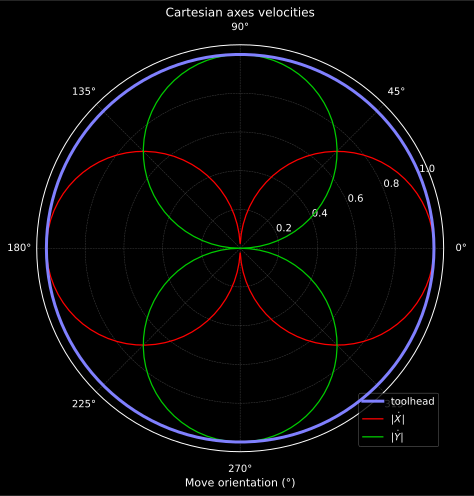

In [2]:
v_x, v_y = x / d, y / d

with fig_tmpl('Cartesian axes velocities', 'velocity'):
    plt.plot(theta, x*0.0+1.0, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

Red and green lines are the velocities of the axes at that constant velocity limit. All the plot will use the convention that a value of 1 represents the target limit.

One of the goal of speed limits is to avoid reaching the step frequencies where the pull-out torque of steppers drops drastically. Notice that, at 45° and 135° degree, the axes moves at $1/\sqrt 2 = 70.7\%$ the speed of the toolhead. This is well bellow the speed limit of the motor, here represented by the value 1.

This next polar plot shows what happens if we limit the velocities of the axes instead of the toolhead. The geometrical procedure for acheiving that requires clipping the X and Y velocity curves to a circle, and then scaling up to our limit $v_\text{max}=1$:

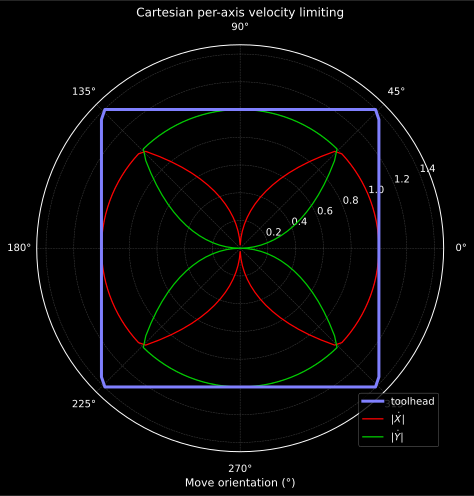

In [3]:
max_vel = 1
#max_vel = np.minimum(max_vel*d/np.abs(x), max_vel*d/np.abs(y))
max_vel = max_vel * d / np.maximum(np.abs(x), np.abs(y))
v_x, v_y = max_vel * x / d, max_vel * y / d

with fig_tmpl('Cartesian per-axis velocity limiting', 'velocity'):
    plt.plot(theta, max_vel, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

When the toolhead is traveling at the speed limit (blue square), there is always one of the two steppers working at its speed limit, characterized by the circle of radius $v_\text{max}=1$.

At an angle of 45°, both motors run at $v_\text{max}$, yielding a combined toolhead velocity of $\sqrt{2}\cdot v_\text{max} \simeq 141\% \cdot v_\text{max}$.

### Acceleration limits

On most printers, like bed slingers and h-bots, one axis is heavier and require more torque to accelerate. To work closer to the machine limits, it is desirable to restrict the acceleration on the heaviest axis (often Y).

Given a normed move orientation vector $ [ r_X \; r_Y ] = [\Delta X \; \Delta Y] / \sqrt{\Delta X^2 + \Delta Y^2} $, we can rewrite the acceleration components as a function of the toolhead acceleration magnitude $a$:

$$
\begin{cases}
\ddot X = a \cdot r_X  \\ 
\ddot Y = a \cdot r_Y \\ 
\end{cases}
$$

Then, for each move, we must scale $a_\text{max}$ to ensure that the acceleration of each steppers stays bounded, observing $ | \ddot X | \leq \ddot X_\text{max} $ and $| \ddot Y | \leq \ddot Y _\text{max} $:

$$
a_\text{max} = \min \left( \frac{\ddot X_\text{max}}{|r_X|}, \, \frac{\ddot Y_\text{max}}{|r_Y|} \right)
$$

In polar coordinate, $a_\text{max}$ will show up as a rectangle. For example with $X_\text{max} = 1$ and $Y_\text{max} = 3/4$:

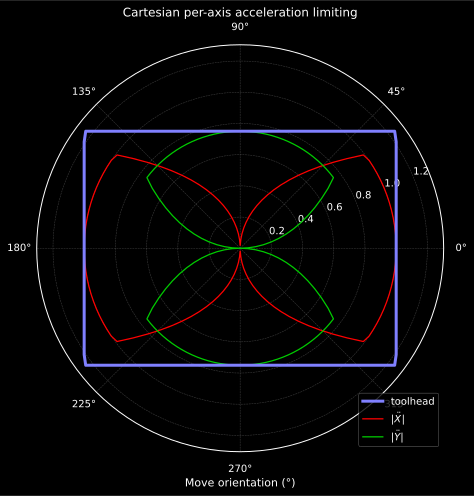

In [4]:
max_acc_x = 1
max_acc_y = 0.75
max_acc = d/np.maximum(np.abs(x)/max_acc_x, np.abs(y)/max_acc_y)
v_x, v_y = max_acc * x / d, max_acc * y / d

with fig_tmpl('Cartesian per-axis acceleration limiting', 'acceleration'):
    plt.plot(theta, max_acc, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(v_x), label='$|\ddot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(v_y), label='$|\ddot Y|$', **plt_kwargs['Y'])

The angle with maximum acceleration is given by $\arctan \frac{\ddot Y_\text{max}}{\ddot X_\text{max}}$ ($\simeq 37°$ here).

Some printers have a torquier motor on Y, often acheiving a lower top speed due to higher back EMF and inductance. This could be a motivation to use different velocity limits on X and Y axes. The velocity profile will be a rectangle, exactly like the acceleration above.

## CoreXY

[CoreXY](http://corexy.com/theory.html) uses a different belt path allowing the motors to stay stationnary. The forward and reverse kinematics are:

$$
\begin{cases}
2X = A + B \\ 
2Y = A - B \\ 
\end{cases}
$$

$$
\begin{cases}
A = X + Y \\ 
B = X - Y \\ 
\end{cases}
$$ $A$ and $B$ designate the motor position. In order to avoid confusion with angular position A and B will be called "belt" positions.

Since these relations are linear, the equations works equaly for position, velocity and acceleration.

### Velocity limits

A constant toolhead velocity $v$ requires belt velocites of up to $\sqrt{2}\cdot v$:

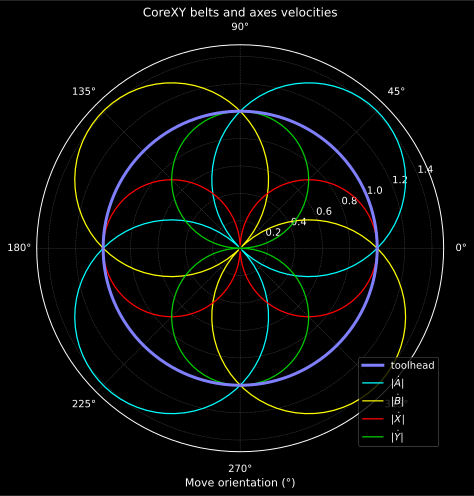

In [10]:
v_x, v_y = x / d, y / d
v_a, v_b = v_x + v_y, v_x - v_y

with fig_tmpl('CoreXY belts and axes velocities', 'velocity'):
    plt.plot(theta, np.hypot(v_x, v_y), label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(v_a), label='$|\dot A|$', **plt_kwargs['A'])
    plt.plot(theta, np.abs(v_b), label='$|\dot B|$', **plt_kwargs['B'])
    plt.plot(theta, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

X and Y velocities are identical to the cartesian plot. However, we now have to look at the belt velocities (or OD velocities of motor pulleys if you want), A and B. They form bigger pairs of circles, rotated by 45° compared to X and Y. This is caused by the factor 2 and the diagonal projection in the kinematics equation.

For accelerations, Klipper's constant limiting will look exactly the same, thanks to the linearity of the kinematic equation.

Limiting the belt velocities, or equivalently, clipping the A and B curves to a circle, decreases the max toolhead velocities on diagonals, with minimums at 45° and 135°:

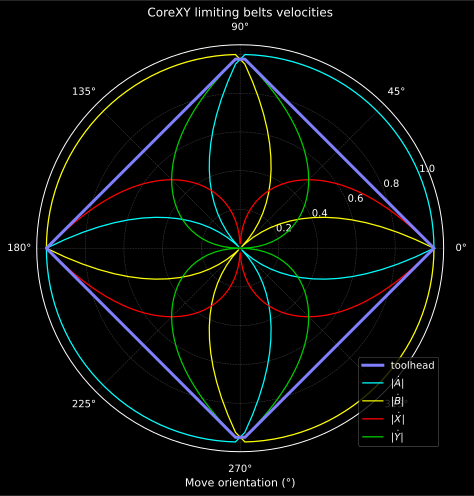

In [6]:
max_vel = 1
max_vel *= d/np.maximum(np.abs(x+y), np.abs(x-y))
v_x, v_y = max_vel * x / d, max_vel * y / d
v_a, v_b = v_x + v_y, v_x - v_y


with fig_tmpl('CoreXY limiting belts velocities', 'velocity'):
    plt.plot(theta, max_vel, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(v_a), label='$|\dot A|$', **plt_kwargs['A'])
    plt.plot(theta, np.abs(v_b), label='$|\dot B|$', **plt_kwargs['B'])
    plt.plot(theta, np.abs(v_x), label='$|\dot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(v_y), label='$|\dot Y|$', **plt_kwargs['Y'])

Unlike cartesian, the motor velocities on CoreXY match the toolhead velocity when the max speed is acheived (at 0° and 90° orientation). However, in practive limiting motor velocity yields, again, a potential 41% increase of top speed, compared to just limiting the toolhead velocity.

### Torque limiting

On cartesian printers, acceleration is a direct proxy for torque since each moving mass accelerate on it own independant axis. This is no longer true for CoreXY where the effects of inertia felt by the motor working together or against each other depend on the orientation. The forces exerced on the toolhead are related to the accelerations and the masses involved:

$$
\begin{cases}
F_X = m_X \ddot X \\ 
F_Y = m_Y \ddot Y \\ 
\end{cases}
$$

where

$$
\begin{cases}
m_X = m_\text{toolhead} \\
m_Y = m_\text{toolhead} + m_\text{gantry}
\end{cases}
$$

On the belts, at the motors, we get the forces:

$$
\begin{cases}
F_A = m_X \ddot X + m_Y \ddot Y \\ 
F_B = m_Y \ddot X - m_Y \ddot Y \\ 
\end{cases}
$$

The following plot shows the forces for masses $m_\text{toolhead}=1$, $m_\text{gantry}=2/3$ and unitary acceleration:

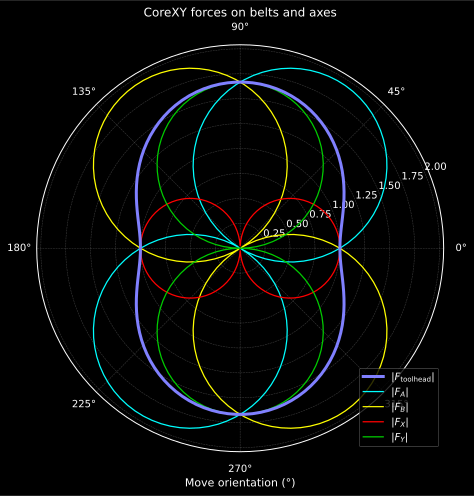

In [7]:
m_toolhead = 1
m_gantry = 2/3
m_x = m_toolhead
m_y = m_toolhead + m_gantry

a_x = x / d
a_y = y / d

f_x = m_x * a_x
f_y = m_y * a_y
f = np.hypot(f_x, f_y)

f_a = f_x + f_y
f_b = f_x - f_y

with fig_tmpl('CoreXY forces on belts and axes', 'force'):
    plt.plot(theta, f, label=r'$|F_\mathrm{toolhead}|$', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(f_a), label='$|F_A|$', **plt_kwargs['A'])
    plt.plot(theta, np.abs(f_b), label='$|F_B|$', **plt_kwargs['B'])
    plt.plot(theta, np.abs(f_x), label='$|F_X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(f_y), label='$|F_Y|$', **plt_kwargs['Y'])

If the displaced masses were equal in every direction ($m_X=m_Y$), we would again get the same profile as "CoreXY belts and axes velocities".
Instead, the magnitude of the force on the toolhead (blue line) is squished horizontally: moving the toolhead plus gantry in the Y direction requires more force than just moving the toolhead in the X direction. As a result, the pairs of circles for the forces on A and B are rotated closer to the vertical axis.


With the cartesian kinematics we substituted the axis accelerations by the magnitude of toolhead acceleration and normed move orentation components. Here, we do the same for our forces, yielding:

$$
\begin{cases}
F_A = a (m_X r_X + m_Y r_Y) \\ 
F_B = a (m_Y r_Y - m_Y r_Y) \\ 
\end{cases}
$$

Then we derive the maximum acceleration such that we don't exceed the available torque, or equivalently, such that $F_A \leq F_\text{max}$ and $F_B \leq F_\text{max}$ (supposing that motors have equal torque):

$$
\begin{align}
a_\text{max} &= \min \left( \frac{F_\text{max}}{|m_X r_X + m_Y r_Y|},\, \frac{F_\text{max}}{|m_X r_X - m_Y r_Y|} \right) \\
    &= \frac{ F_\text{max} }{ \max \left( |m_X r_X + m_Y r_Y|,\, |m_X r_X - m_Y r_Y| \right) } \\
%    &= \frac{ F_\text{max} \sqrt{\Delta X^2 + \Delta Y^2} }
%            { \max \left( |m_X \Delta X + m_Y \Delta Y|,\, |m_X \Delta X - m_Y \Delta Y| \right) }
\end{align}
$$

Again, with Klipper's constant acceleration limiting, the acceleration plot shares the profile of "CoreXY belts and axes velocities". Instead, when limiting the forces at the belts to $F_\text{max}=1$, we are now getting these accelerations:

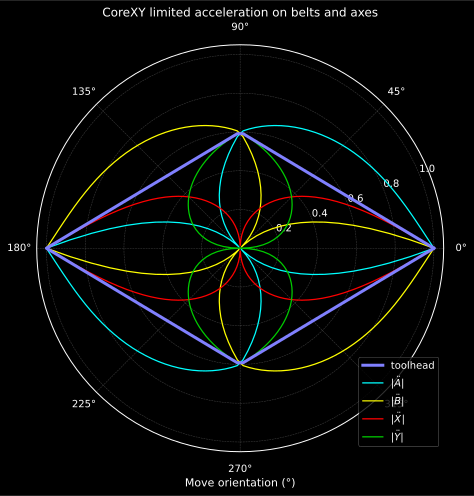

In [8]:
f_max = 1
m_x = 1
m_y = m_x + 2/3

r_x = x / d
r_y = y / d

#a = np.minimum(f_max / np.abs(m_x * r_x + m_y * r_y), f_max / np.abs(m_x * r_x - m_y * r_y))
#a = f_max / np.maximum(np.abs(m_x * r_x + m_y * r_y), np.abs(m_x * r_x - m_y * r_y))
#a = f_max * d / np.maximum(np.abs(m_x * x + m_y * y), np.abs(m_x * x - m_y * y))
amax_x = f_max / m_x
amax_y = f_max / m_y
a = d / np.maximum(np.abs(x / amax_x + y / amax_y), np.abs(x / amax_x - y / amax_y))

a_x = a * r_x
a_y = a * r_y

a_a = a_x + a_y
a_b = a_x - a_y

with fig_tmpl('CoreXY limited acceleration on belts and axes', 'acceleration') as f:
    plt.plot(theta, a, label='toolhead', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(a_a), label='$|\ddot A|$', **plt_kwargs['A'])
    plt.plot(theta, np.abs(a_b), label='$|\ddot B|$', **plt_kwargs['B'])
    plt.plot(theta, np.abs(a_x), label='$|\ddot X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(a_y), label='$|\ddot Y|$', **plt_kwargs['Y'])

#### Parametrization

The formula above requires specifying the masses of the system and the maximum force that the motors can apply on the belts. Empirically, it is easier to measure the maximum acceleration at which the motors start skipping steps. Noticing that a force divided by an mass is an acceleration, we can write the formula in such a way that they are instead parametrized by the maximum accelerations at 0° and 90°:

$$
\begin{align}
a_\text{max} &= \frac{ F_\text{max} }{ \max \left( |m_X r_X + m_Y r_Y|,\, |m_X r_X - m_Y r_Y| \right) } \\
\frac{1}{a_\text{max}}  
  &= \max \left( 
       \left| \frac{m_X}{F_\text{max}} r_X + \frac{m_Y}{F_\text{max}} r_Y \right|,\, 
       \left| \frac{m_X}{F_\text{max}} r_X - \frac{m_Y}{F_\text{max}} r_Y \right|
    \right)  \\
  &= \max \left( 
       \left| \frac{r_X}{\ddot X_\text{max}} + \frac{r_Y}{\ddot Y_\text{max}} \right|,\, 
       \left| \frac{r_X}{\ddot X_\text{max}} - \frac{r_Y}{\ddot Y_\text{max}} \right|
    \right)
\end{align}
$$

#### Lowest acceleration

The minimum acceleration $a_\text{min}$ on diagonal moves is the altitude of the blue triangles. Inverse Pythagorean theorem yields:

$$ a_\text{min}^{-2} = \ddot X_\text{max}^{-2} + \ddot Y_\text{max}^{-2} $$

The angle $\beta_\text{min}$ of this altitude is the same as the one found at the top of the blue triangle, between the 90° axis and its hypoteneuse:

$$ \beta_\text{min} = \arctan \frac{\ddot X_\text{max}}{\ddot Y_\text{max}} $$

For cartesian per-axis limited acceleration we got curves clamped to circles. The acceleration plot for CoreXY doesn't exactly look like that. This is because we clamped the *forces* on the belts instead of their acceleration. Then let's check that the forces are indeed clamped when applying our acceleration limits:

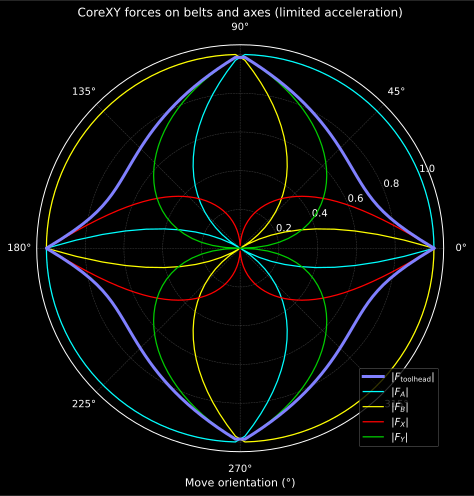

In [9]:
f_x = m_x * a_x
f_y = m_y * a_y
f = np.hypot(f_x, f_y)

f_a = f_x + f_y
f_b = f_x - f_y

with fig_tmpl('CoreXY forces on belts and axes (limited acceleration)', 'force'):
    plt.plot(theta, f, label=r'$|F_\mathrm{toolhead}|$', **plt_kwargs['toolhead'])
    plt.plot(theta, np.abs(f_a), label='$|F_A|$', **plt_kwargs['A'])
    plt.plot(theta, np.abs(f_b), label='$|F_B|$', **plt_kwargs['B'])
    plt.plot(theta, np.abs(f_x), label='$|F_X|$', **plt_kwargs['X'])
    plt.plot(theta, np.abs(f_y), label='$|F_Y|$', **plt_kwargs['Y'])